In [1]:
from tqdm import trange, tqdm
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *

In [143]:
PTS = 50 
WINDOW = 8
STEPS = 5

## нумерация идет с начала обозрений до смены тренда
### TODO: подогнать прогнозирование 

In [3]:
# loading patterns that we use
patterns_for_supercomp=[]
fi = open("patterns/patterns_supercomp_7.txt", "r")
for line in fi:
    temp = list(map(int, line.split(", ")))
    patterns_for_supercomp.append(temp)
fi.close()


In [4]:
def parse(pattern, pattern_motifs):
    f = open('motifs/motifs_7_3/thamotifs%s.txt' % ''.join(map(str, pattern)), 'r')
    f.readline()
    temp_arr = []
    for line in f:
        line = list(map(float, line.split(", ")))
        temp = []
        for x in pattern:
            temp.append(line[x])
        temp_arr.append(temp)
    
    pattern_motifs[str_subseq(pattern + (WINDOW - 1,))] = temp_arr
    f.close()
    return pattern_motifs


def new_parse(pattern, pattern_motifs):
    f = open('motifs/motifs_7_3/thamotifs%s.txt' % ''.join(map(str, pattern)), 'r')
    f.readline()
    temp_arr = []
    for line in f:
        line = list(map(float, line.split(", ")))
        temp_arr.append(line)
    
    pattern_motifs[str_subseq(pattern + (WINDOW - 1,))] = temp_arr
    f.close()
    return pattern_motifs


In [5]:
def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight


def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight


def krutoi_prediction(mode, start_point, step, center):
    if mode == "dist":
        pred = aggr_d(center)
    elif mode == "q-val":
        pred = aggr_q(center)
    return pred


def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))


def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    

def detrend(data_matrix):
    ans = []
    for data_list in data_matrix:
        series = pd.Series(data_list)
        X = [i for i in range(0, len(series))]
        X = np.reshape(X, (len(X), 1))
        y = series.values
        model = LinearRegression()
        model.fit(X, y)
        beta = model.intercept_
        alpha = model.coef_
        trend = model.predict(X)
        detrended = [y[i]-trend[i] for i in range(0, len(series))]
        ans.append(detrended)
    return ans, beta, alpha



In [6]:
# loading patterns and motifs that we use
centers = dict()
for pattern_from_file in patterns_for_supercomp:
    parse(tuple(pattern_from_file), centers)

In [149]:
def generate_predictions(centers, return_set_pred=False, real_mode='test', EPS=0.1, Q_VALUE=0.96):
    #centers - словарь, какой ключ и значение хуй их пойми (судя по всему паттерн - ряд загенеренный по этому паттерну)
    #patterns - лист таплов паттернов 
    #xs - наш ряд по которому мы предсказываем
    
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = 150 #len(xs) - PTS - WINDOW - 1 #val_end; LEN(arr) - PTS - WINDOW - 1  
        init_point = 180 #len(xs) - PTS-1 #test_init LEN(arr) - PTS
    else:
        end_point = train_end
        init_point = val_init

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[end_point + start_point : init_point + start_point])) #проверить строчку!!!

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,))
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector[:-1], center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), chosen_centers))
            
            # deamon predict
            result_point = krutoi_prediction("dist", start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], chosen_centers))))
            else:
                q_value = None
            
            # move the window
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

#     deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

66
0.12694960625826007 0.010613359274426285


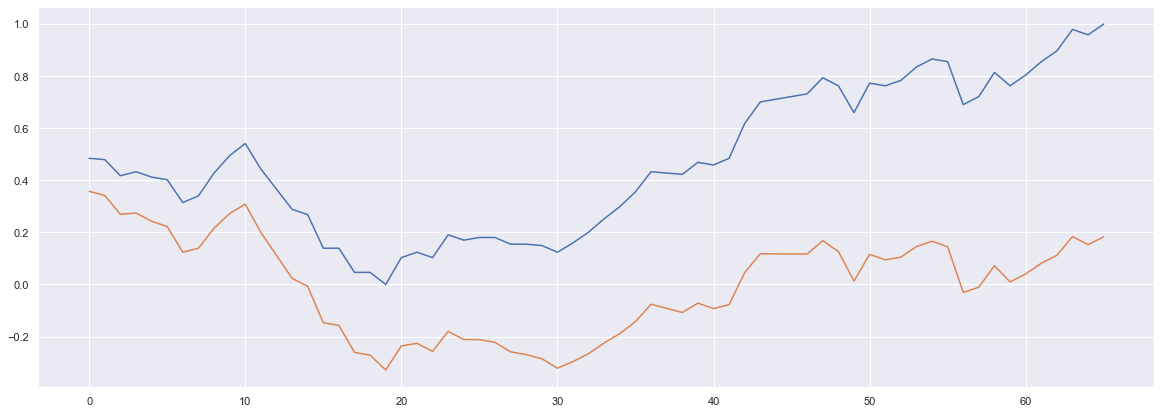

In [153]:
df = pd.read_csv('data/test/part_1.csv')
#trustworthy series 5  - 44, 5009,300, 190
df_pred = df.loc[df.index == 190]
df_pred = df_pred.drop(labels=['Ticker', 'index', 'Date'], axis=1)
df_pred = df_pred.dropna(axis=1)

xs_temp = df_pred.values.tolist()
xs_temp[0] = xs_temp[0][::-1]
sns.set(rc={'figure.figsize':(20,7)})
sns.lineplot(y=xs_temp[0], x=list(range(len(xs_temp[0]))))
xs, beta, alpha = detrend(xs_temp)
alpha = float(alpha)
xs = list(np.array(xs).flatten())
print(len(xs))
sns.lineplot(y=xs, x=list(range(len(xs))))
print(beta, alpha)
patterns = []
for x in centers.keys():
    temp = tuple(map(int, x.split(",")))
    patterns.append(temp[:-1])


# BEHOLD THE MIGHTY PREDICTION 

In [150]:
predicted_points = generate_predictions(centers)

100%|███████████████████████████████████████████| 50/50 [00:21<00:00,  2.32it/s]


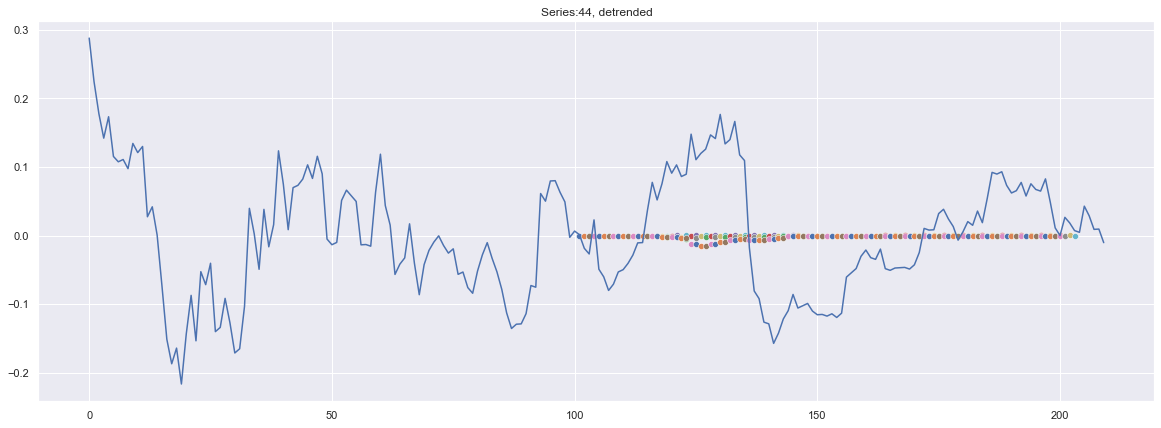

In [151]:
sns.set(rc={'figure.figsize':(20,7)})
sns.lineplot(y=xs, x=list(range(len(xs))))

endpoints = []
prikol = {}
for x in predicted_points.items():
    start_point, predicted_values = x[0], x[1]
    for counter in range(len(predicted_values)):
        if predicted_values[counter] != None:
#             X = len(xs) - WINDOW - PTS - 1 + start_point + counter
            X = 100 + start_point + counter
            temp_kostyl = prikol.get(X)
            if temp_kostyl == None:
                prikol[X] = [predicted_values[counter]]
            else:
                prikol[X].append(predicted_values[counter])
            sns.scatterplot(y=np.array([predicted_values[counter]]), x=X).set_title("Series:44, detrended")
            
# predicted_array = []
# for counter in range(len(xs), len(xs) - 7, -1):
#     predicted_array.append(np.mean(prikol[counter]))

# predicted_array = predicted_array[::-1]
# print(predicted_array)

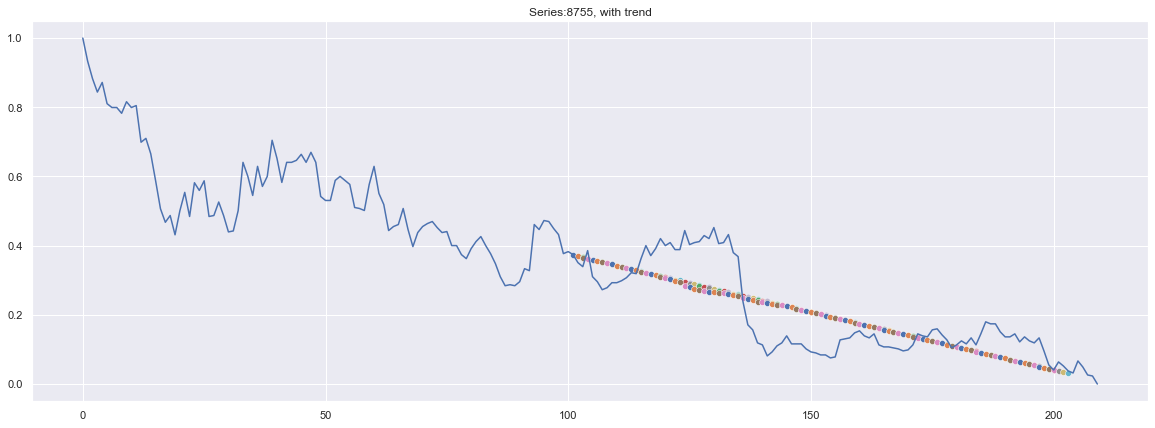

In [152]:
sns.lineplot(y=xs_temp[0], x=list(range(len(xs_temp[0]))))
for x in predicted_points.items():
    start_point, predicted_values = x[0], x[1]
    for counter in range(len(predicted_values)):
        if predicted_values[counter] != None:
#             X = len(xs) - WINDOW - PTS - 1 + start_point + counter
            X = 100 + start_point + counter
            temp = predicted_values[counter] + beta + alpha * X
            if X == len(xs):
                endpoints.append(temp)
            sns.scatterplot(y=np.array([temp]), x=X).set_title("Series:8755, with trend")



0.0007259391549327055 0.043522264595038496


<AxesSubplot:>

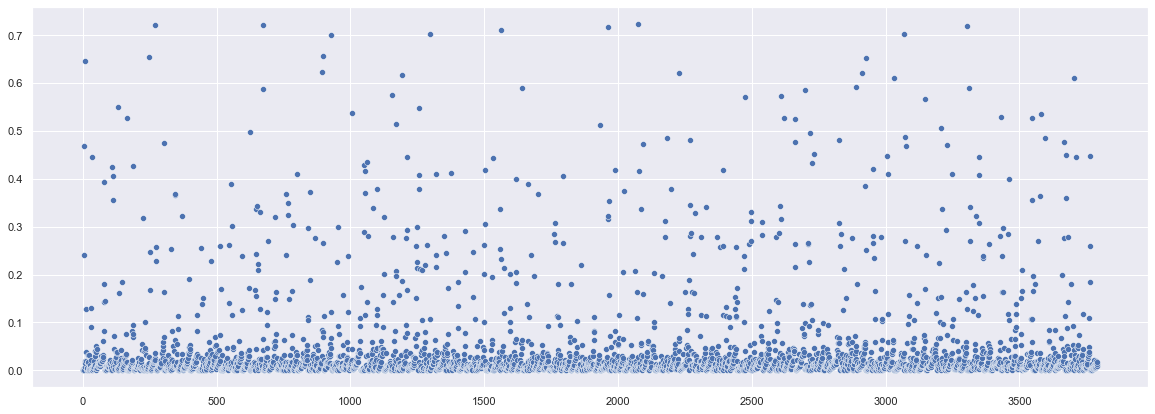

In [107]:
#"resemblence" of motifs that lead to a change of trend
def new_parse(pattern, pattern_motifs):
    f = open('motifs/motifs_7_3/thamotifs%s.txt' % ''.join(map(str, pattern)), 'r')
    f.readline()
    temp_arr = []
    for line in f:
        line = list(map(float, line.split(", ")))
        temp_arr.append(line)
    
    pattern_motifs[str_subseq(pattern + (WINDOW - 1,))] = temp_arr
    f.close()
    return pattern_motifs



# loading patterns that we use
patterns_for_supercomp=[]
fi = open("patterns/patterns_supercomp_7.txt", "r")
for line in fi:
    temp = list(map(int, line.split(", ")))
    patterns_for_supercomp.append(temp)
fi.close()

new_centers = dict()
for pattern_from_file in patterns_for_supercomp:
    new_parse(tuple(pattern_from_file), new_centers)

distances = {} 

for key, value in new_centers.items():
    for motif in value:
        temp_dist = euclidean(predicted_array, motif)
#         print(motif, temp_dist, i)
        distances[tuple(motif)] = temp_dist
        
visual_arr = list(distances.values())
print(min(visual_arr), np.mean(visual_arr))
sns.scatterplot(y=visual_arr, x=list(range(len(visual_arr))))

# Мотивы длиной 7

[0.000843093974917024, 0.0001568658553620581, 1.736933493736347e-06, -0.0007360180455023463, -0.0012661931913823456, -0.0011094003410156508, 0.0021099148141275254] 0.02938982419368966 1
[3.6450417649256694e-20, -6.66060828365571e-21, -9.668834264512429e-20, -1.1272871240222342e-19, -4.043309475891536e-21, 1.0811402292233795e-18, 1.7267298956012724e-20] 0.029208696508655405 1
[3.708295678828089e-10, -4.419188373448325e-10, 9.357969391455751e-11, -7.561144585956657e-11, -8.160333248623678e-11, 3.3924638487515773e-13, 1.3438518335383522e-10] 0.02920869628984359 1
[-0.0036113338814715962, 0.0014200563831411332, 0.0015056447134678985, 0.0019006239115465346, 0.0014747714081827742, -0.00010627203175298062, -0.0025834905031138083] 0.030067851904190535 1
[-5.219734758267066e-09, 4.673760823805507e-09, 1.090127845168746e-09, 1.2884964547253865e-09, -6.343982689489413e-10, 9.92400359090405e-10, -2.190652414369838e-09] 0.02920869872162705 1
[-0.007108973867239673, -0.0052480881899836795, 0.0177627

[-0.0039533925769096, -0.0018986675908335535, 0.0014686613134674514, 0.004857061349802426, 0.006471785885823186, -0.00017570765929790134, -0.006769740722051939] 0.029835422836898395 1
[-0.003570795647698028, -0.008289653998961588, 0.009352051814776148, 0.005476305890665624, 0.006402706902352007, -0.0037694948548086435, -0.005601120106325287] 0.02816188997715499 1
[9.819404863340781e-05, 0.0045767410669788205, -0.007836437050383881, 0.004519056792633688, -0.0031161152067287388, 0.000547938610397418, 0.0012106217384692866] 0.03330408066352325 1
[-0.00447037477431581, 0.0053838857164227455, 0.0024714298466245385, -0.0008288633564878386, -0.0041338197584977025, 0.0007713302637419552, 0.0008064120625121283] 0.032920593991389066 1
[0.0041736655398606414, -0.001745084477714581, 0.0026003599751048666, -0.0022602697624821352, -0.009589793922923185, -0.000757613617718053, 0.007578736265872323] 0.03135389673233893 1
[-0.008625564036411543, 0.0030887786693556685, 0.0060583121689695525, 0.004026792

[0.017673205477589406, -0.00035625619506570046, -0.01036768191927846, -0.01629851353496929, -0.01013700966066397, 0.006382335713141674, 0.013103920119246342] 0.04519410046658052 1
[0.010324007112685937, -0.0005083273519221833, -0.006440274639911682, -0.010801917136329739, -0.001368780720266968, 0.0015020054926650121, 0.007293287243079572] 0.03566843345972579 1
[-0.001732374950497495, 0.006701008643928074, 0.009452811419405086, -0.016414357685445264, 0.0012256203299938222, -0.014130206797927754, 0.01489749904054347] 0.04302476027079688 1
[-0.02197100874854724, -0.005950131798294869, 0.017171199024259103, 0.027786452240208617, 0.009227547360392916, -0.008922536055690405, -0.017341522022328155] 0.04905755160805598 1
[-3.261586478120867e-06, -3.5117303936537804e-07, 1.7342855597979792e-06, 3.3370845125901473e-06, 1.8223538794111847e-06, 7.322805296500074e-07, -4.013244964011987e-06] 0.02920808937407571 1
[-7.77259337243079e-06, -1.2414586765011237e-05, 1.2120052145445227e-05, 3.98391885916

[0.0030043882601536644, -0.0017062290790252786, -0.002416774921854957, -2.0545349284535896e-05, -0.0009088561085622379, 0.002051263786602397, -3.2465880290151963e-06] 0.029172169413385494 1
[0.002448392447037282, -0.0004803247571249626, -0.00219499799506768, 0.0002838855673667841, -0.0030608735747541895, 0.001761351531079515, 0.0012425667814631276] 0.02973321454826209 1
[0.0002646313398732503, -0.003968610093271725, 0.004814608043800341, 0.001779169641166339, -0.0017528400835320622, -0.002834998504516778, 0.001698039656480764] 0.027223148805986273 1
[-0.010094504906882625, 0.001197580345695788, 0.007600654974604283, 0.0032287914090465327, 0.007839562600092151, -0.0011889916129242829, -0.008583092809631874] 0.03365034289722619 1
[0.008297606171393314, -0.014663707726171501, 0.0009312438642899978, 0.0029801443271359187, 0.005281351959062302, 0.0003047892458052536, -0.0031314278415153236] 0.027115251567933246 1
[-0.012529061201361099, -0.010829542700024739, 0.015490297647832111, 0.0113266

[-0.0024806812276530303, -0.002115970003301319, 0.004508089804512172, 0.003370839626437253, 0.003537844376787165, -0.009756629468509477, 0.002936506891727421] 0.02901208127192676 1
[0.008413404410323493, -0.008936482253312908, -0.001854355111375327, 0.0033799122262236996, -0.0049296771859518775, 0.0013390229433577338, 0.0025881749707352417] 0.0280305403068052 1
[-0.00110890316881419, 0.0034277299551104547, 0.003120666123762252, 0.0018768388965790903, -0.01213918395690347, -0.004320044033646543, 0.009142896183912388] 0.03425212218152017 1
[0.0031381667537399294, -0.01014587336810788, 0.0016941798909166084, 0.004205612320516169, 0.004396239611304467, 0.0037143305702756597, -0.007002655778645047] 0.027607982171341534 1
[-0.004813570977695993, 0.009303622672676225, 0.005631952170342308, -0.005082451267474933, -0.011772388445961526, -0.0013723654842266516, 0.008105201332340533] 0.03869512599320355 1
[0.004179159932923495, -0.002752417390009374, -0.00256686314737651, 0.010275870995614422, -0

[0.004524651048560328, 0.0019569422186967536, -0.004445982811906485, -0.004569964727566188, -0.003097100669410878, 0.0007554093843006109, 0.004876045557325881] 0.03263083011960146 1
[-0.01649466308493119, -0.010081834657270694, 0.019890996935585683, 0.022757831810630617, 0.003850766116712149, -0.006161863611718326, -0.01376123350900827] 0.04248949868182345 1
[0.006804793153473729, -0.00018825487332175197, -0.0030653187743247784, -0.007352612481853988, -0.003884747626654711, 0.0022011232419368383, 0.005485017360744652] 0.032946073049447105 1
[-0.009843982408680082, -0.0008589429963562399, 0.006443936517714005, 0.006070260643460508, 0.008135255525026386, 0.0031015703825716923, -0.013048097663736175] 0.0346606910958916 1
[0.006429424258459021, 0.0018885700590016772, -0.0010585261280252741, -0.006483873789745772, -0.009628972130823954, -0.0050757257027762084, 0.013929103433910503] 0.03637215334729219 1
[0.0009241427243888824, 6.250041566879312e-05, 1.943297653373142e-05, -0.000993973164694

[-0.0014830731586375925, -0.00023108281773506328, 0.0011728642846885276, 0.0013222563251021544, 0.001537291441079609, -0.0016789559557188693, -0.0006393001187787506] 0.02884358171906599 1
[-0.0007219630736834534, -0.000722213719617825, 0.0011121124692919902, -5.018251377134704e-05, 0.0015571218586613138, 0.0005307009870133925, -0.001705576007894042] 0.02896425379974305 1
[0.000939984596581582, 0.0001767695344305615, -0.0001758157201643535, -0.0021120269709111023, 0.0011854847420729128, -0.0018553809423975665, 0.0018409847603879155] 0.029571156976195678 1
[-0.0030797309791524164, -0.0026478401366380423, 0.002574044294474282, 0.006164730208894162, 0.0022346853746062, -0.0015421519956878797, -0.003703736766496501] 0.028193702396794005 1
[-0.00433041254546544, -0.0007374971540322683, 0.0060808215757733874, 0.005134303277525726, -0.00048364251672445847, -0.009088950059267714, 0.0034253774221908286] 0.029765820846483857 1
[0.0019658738646623807, -0.0005503377044396309, -0.003216456521818427,

[0.0030329659675306783, 0.000475395503802303, -0.0008827508761513114, -0.0033507817381018762, -0.0030327810735425406, -0.0009258624581994765, 0.004683814674662279] 0.0253915381345606 3
[0.0013700589956989835, -0.00251592557323273, 0.0019857251509425218, -0.00015180892254790837, -0.0007435916660583329, -0.0016410166120396728, 0.0016965586272372367] 0.02061057750731202 3
[0.002588109888408965, 0.0016808018147077886, -0.0006274811305383918, -0.0037121590653364186, -0.004819937065253893, -0.000646392555321903, 0.005537058113333938] 0.026844704546382422 3
[0.0010965989269120006, -0.0007950317578657345, 0.0012754702478914005, -0.0017320922248974197, -0.0014512506139705836, 0.00039246213892445354, 0.0012138432830058584] 0.022645599981039103 3
[0.004589419749079692, -0.0018879465640465752, -0.003142325169678507, -0.002468632715481797, 0.000549789533217243, 0.0007788340844796554, 0.0015808610824302831] 0.023632984925290236 3
[0.000503413376853772, -0.003099535540581189, 0.005166554469809927, -0

[-0.0005980774045775836, -0.0019048598456784, 0.003503198314497787, 0.0022071519044757184, -0.0003741185183625262, -0.00677324827883567, 0.003939953828480703] 0.020935962486524875 3
[-0.0014404709950196271, -0.005496292279803917, 0.005535100037219196, 0.0017922833110388657, 0.0036876455489536835, 0.001231746189235715, -0.005310011811624217] 0.018574463093276504 3
[-0.0035526173875205015, -0.0077167564148525785, 0.009357931419948121, 0.002045103876336511, 0.0065672688144570255, 0.00319791146167001, -0.009898841770038549] 0.02073025970666197 3
[0.004819451240056006, -0.01169612573464465, 0.002250391655551487, 0.003610408313827685, 0.005089575811050797, -0.0004480219529031906, -0.0036256793329380644] 0.01577114446182035 3
[0.00022181498896769848, -0.00017023951726813952, -0.00019348208129043673, -0.00038913513614763736, 0.00033722784726707096, 0.0007871856916049356, -0.0005933717931335187] 0.022637916804993972 3
[-0.0009855719782937535, -0.0010099013559638464, -0.0005532738196163154, 0.00

[0.003608020460868454, -0.0015197713801918852, -0.0019187026318572594, -0.0005622853779115043, -0.003127525145603716, 0.0015674510881196072, 0.001952812986576278] 0.02332705901212572 3
[-0.002195114229727433, 0.006206760476545324, 0.001185043578365205, -0.004510198995380871, -0.006584442179873724, 0.004096190028067048, 0.001801761322004385] 0.030594692657713588 3
[-0.005936282177195455, -0.013144907106373708, 0.010769977740651753, 0.013408284989505964, 0.009802987577472702, -0.0015685124910292693, -0.013331548533032101] 0.022608072455654354 3
[0.0041657109321125195, 0.004025742898106633, -0.0036104366990934397, -0.007902541560781661, -0.004969438068070883, 0.002965267531652635, 0.005325694966074324] 0.03151101325332006 3
[-0.0034273989117280766, 0.0008621303368221614, 0.002388960950693934, 0.0017705384800980448, 0.0018259217619683336, -0.00226556098074898, -0.0011545916371054543] 0.022339347218655665 3
[-0.0002387429421673112, -0.0058826471105976625, 0.002711355162540762, 0.00338921986

[-0.0005503216684336268, 0.00048073220853711834, 0.00021267407682079123, -0.0001982205201625306, 0.00019078400216267767, 0.00026066621679525205, -0.0003963143157196825] 0.02290695549715855 3
[0.000180217842235887, -0.004751413473974774, 0.0031837104039033454, 0.0007891122426245231, 0.004447298687504438, -0.0013210154020377289, -0.002527910300255851] 0.018580785059871822 3
[-0.001505807129980364, 0.000799640075715296, 0.0010218572555780615, 0.0008110745671779487, -0.0008257334142423253, 0.00016745650594399738, -0.00046848786019269953] 0.022845867606102455 3
[0.00048192174329859553, 1.0734926903335836e-05, -0.00017125090939003912, -0.0006967652305026083, -0.0001715467029471076, 0.00017318764065380176, 0.0003737185319839694] 0.022852182842467136 3
[-0.0005233200192224399, -0.0002002950682251037, -4.8370589480105746e-05, 0.0007270353759618923, 0.001044241521087341, 6.528864432030856e-05, -0.0010645798644418661] 0.022127208187832557 3
[0.0017863944967321977, 1.371333433905572e-05, -0.000969

[0.003195359612733032, -0.0007075826909502439, -0.002002724465740675, -0.0018899630470806852, -0.0018032240461669372, 0.00165299087489157, 0.001555143762313902] 0.023970947645435177 3
[0.0013656741240088213, 0.0006545513973696663, -0.0019900055558659605, -0.0008379391287190648, -0.0009249693259154991, 0.0008569765305507295, 0.0008757119585712915] 0.024048661531152864 3
[0.0008433972646472336, 0.0001061621624812709, 2.6299730525631995e-05, -0.0008722168713333069, -0.0011852618480806102, -0.0007092190122311448, 0.001790838573990926] 0.023090769506426755 3
[-1.1158029957888553e-21, -3.039084283753535e-21, 3.580018144240131e-21, -4.7826077466458145e-22, -5.570437164128944e-21, -8.313089077558477e-22, 1.766682687501252e-22] 0.02253464679112257 3
[0.00024162052063530782, 5.456228087410864e-05, -0.0001913726389020495, -0.0002776514301490725, -6.855381800559706e-05, 1.3017953884135218e-05, 0.00022837713166313757] 0.02271711155124458 3
[-0.007363511098641689, -0.014567059658395264, 0.0128351287

[6.571540697229787e-17, 9.96955785899612e-17, 1.1270600465978726e-16, 1.1265498338108205e-16, 1.2041021774427248e-16, 1.1515502603763686e-16, 5.2807023459882216e-17] 0.022534646791122537 3
[-8.325894161759212e-17, -5.567292206781653e-17, -8.811926649440479e-17, -9.115898124566242e-17, -1.165362876472712e-16, -1.2675841827477168e-16, -2.6464298800273476e-17] 0.022534646791122614 3
[3.6873558823709296e-06, -8.102151676061969e-07, 1.392048811280076e-07, -4.346403148727788e-06, -3.4121095630413297e-06, 1.233549591661471e-06, 3.508617524238987e-06] 0.022535893100629586 3
[-4.3555980928616545e-05, -2.6705361932579497e-05, 3.257308033034097e-05, 5.125595391026884e-05, 6.689377939724513e-05, -2.2985046612096152e-05, -5.7476424164575686e-05] 0.022482921954728938 3
[-9.986714593630162e-05, 1.1730733328666735e-05, -8.839323618875294e-05, 1.618841579426836e-05, 0.00041740485294054384, 1.0747200465327635e-05, -0.0002678108204038455] 0.02251733057084453 3
[-0.0003532322983303251, -0.0002646617921481

[0.000843093974917024, 0.0001568658553620581, 1.736933493736347e-06, -0.0007360180455023463, -0.0012661931913823456, -0.0011094003410156508, 0.0021099148141275254] 0.01930001502421685 7
[3.6450417649256694e-20, -6.66060828365571e-21, -9.668834264512429e-20, -1.1272871240222342e-19, -4.043309475891536e-21, 1.0811402292233795e-18, 1.7267298956012724e-20] 0.018864790458306007 7
[3.708295678828089e-10, -4.419188373448325e-10, 9.357969391455751e-11, -7.561144585956657e-11, -8.160333248623678e-11, 3.3924638487515773e-13, 1.3438518335383522e-10] 0.018864790116497564 7
[-0.0036113338814715962, 0.0014200563831411332, 0.0015056447134678985, 0.0019006239115465346, 0.0014747714081827742, -0.00010627203175298062, -0.0025834905031138083] 0.019896875186930424 7
[-5.219734758267066e-09, 4.673760823805507e-09, 1.090127845168746e-09, 1.2884964547253865e-09, -6.343982689489413e-10, 9.92400359090405e-10, -2.190652414369838e-09] 0.018864793657900045 7
[-0.007108973867239673, -0.0052480881899836795, 0.01776

[0.00783761563192954, 0.003778334955927535, -0.011513739961221474, -0.008729224272260111, 0.0030331488383213176, 0.0002589664138086318, 0.005334898393494569] 0.030958015866955332 7
[-0.0039533925769096, -0.0018986675908335535, 0.0014686613134674514, 0.004857061349802426, 0.006471785885823186, -0.00017570765929790134, -0.006769740722051939] 0.019236206045914236 7
[-0.003570795647698028, -0.008289653998961588, 0.009352051814776148, 0.005476305890665624, 0.006402706902352007, -0.0037694948548086435, -0.005601120106325287] 0.015890756418144948 7
[9.819404863340781e-05, 0.0045767410669788205, -0.007836437050383881, 0.004519056792633688, -0.0031161152067287388, 0.000547938610397418, 0.0012106217384692866] 0.025127493715151505 7
[-0.00447037477431581, 0.0053838857164227455, 0.0024714298466245385, -0.0008288633564878386, -0.0041338197584977025, 0.0007713302637419552, 0.0008064120625121283] 0.024127694853163587 7
[0.0041736655398606414, -0.001745084477714581, 0.0026003599751048666, -0.002260269

[0.020038225004799702, -0.020715913663500212, -0.01350349410061399, -0.0018076407897523884, 0.013010634649973138, 0.016765847760469663, -0.013787658861375911] 0.03983816070038875 7
[-0.0037938575287239625, 0.0024315006584328842, 0.002524069830320109, 0.0013196854966011637, -0.0010880562871811764, -0.0012735813565425392, -0.00011976081290658584] 0.02053809142899374 7
[-0.0005690355592795647, -0.0071083444006013324, 0.0022459878980556985, 0.004103028741984442, 0.0056596472117353015, 0.006343603117037716, -0.010674887008932172] 0.019279966582004107 7
[-0.011402407366531636, 0.007401514026269487, 0.0017191831113575764, -0.0011360625682453676, 0.02272261939006266, -0.01750690945297719, -0.0017979371399355377] 0.038603308464633695 7
[0.003873016504908876, -0.01417504367750862, -4.465776994672377e-05, 0.009420211172109479, 0.0035139182129757924, 0.012527280495596853, -0.015114724938135643] 0.024617840195002388 7
[0.015317763425963424, 0.0015779097843229787, -0.017193622095436446, -0.006347324

[-0.0037269568234175082, -0.0011924575281981914, 0.0002851469614076534, 0.009015351562533809, 0.000760409860138755, -0.001383433672013286, -0.003758060360451148] 0.018545760145719587 7
[-0.002383067365940456, -0.003628938901506329, 0.0034833789732070805, 0.0023644626074978705, 0.006508626290964149, -0.0016010575940759847, -0.004743404010146373] 0.017068475874171936 7
[-0.011563719323257456, -0.0001708063391534478, 0.00994526835578062, 0.001445258241097682, 0.010315857740205967, 0.005487784008484625, -0.015459642683157963] 0.02965860543599783 7
[0.0026152773163896346, -0.0017109380841604843, -0.0011434559017871823, -0.0030647275602889343, 0.002630842370404071, 0.0013693480696718768, -0.0006963462102290442] 0.01937815871087218 7
[-0.0001278985641126298, -0.00737895702147906, 0.003653997123149717, 0.003807425352568209, 0.005082247342559011, 0.0014594172566495995, -0.006496231489334854] 0.015151183383810314 7
[0.002192617823825691, -0.0034513963981799667, 0.0004578861668122206, -0.00129883

[0.0008433972646472336, 0.0001061621624812709, 2.6299730525631995e-05, -0.0008722168713333069, -0.0011852618480806102, -0.0007092190122311448, 0.001790838573990926] 0.019277275826832793 7
[-1.1158029957888553e-21, -3.039084283753535e-21, 3.580018144240131e-21, -4.7826077466458145e-22, -5.570437164128944e-21, -8.313089077558477e-22, 1.766682687501252e-22] 0.018864790458306007 7
[0.00024162052063530782, 5.456228087410864e-05, -0.0001913726389020495, -0.0002776514301490725, -6.855381800559706e-05, 1.3017953884135218e-05, 0.00022837713166313757] 0.019023351061337634 7
[-0.007363511098641689, -0.014567059658395264, 0.012835128783573374, 0.016028582594642148, 0.00828205418077164, 0.0010259936040633618, -0.01624118840601357] 0.026434784145686997 7
[-0.005534471557946338, 0.0029288660301740673, -0.008024441237331491, 0.01710526426222672, -0.0028401090623942503, 0.005024689484242202, -0.008659797918970851] 0.029641816931119492 7
[0.003355194132477509, 0.000996315904212866, -0.000712534070480611

[0.002476250390242993, -0.0017206961284907396, -3.383518474053242e-05, -0.003252280147476162, 0.004306972554770913, -0.004975785627155069, 0.0031993741428487247] 0.01960087827466794 7
[-0.005701344594288708, 0.0007854320177249355, 0.003485974589022642, 0.0034022324010078166, 0.006172559383153066, -0.006214806848312102, -0.0019300469483074876] 0.020637841628819344 7
[0.005322831426213535, 0.0029634763147255256, -0.005718571250600898, -0.010445440130860318, 0.004453048661353304, -0.0014498620586309546, 0.004874517037799797] 0.028240893092911487 7
[-0.010047297131443965, -0.004089541179391051, 0.010325042762393011, 0.01870358065548141, -0.005204900515393643, -0.00626962329960979, -0.003417261292035925] 0.024814439848384665 7
[0.009922173671543239, 0.010435903933286412, -0.00396310343185449, -0.02339305327412757, -0.016049450267578654, 0.006417912389266412, 0.016629616979464624] 0.04787976341507891 7
[0.017889761269156822, 0.00035418726772888984, -0.014479714656913048, -0.02560115061195688

0.011766500058839334


<AxesSubplot:>

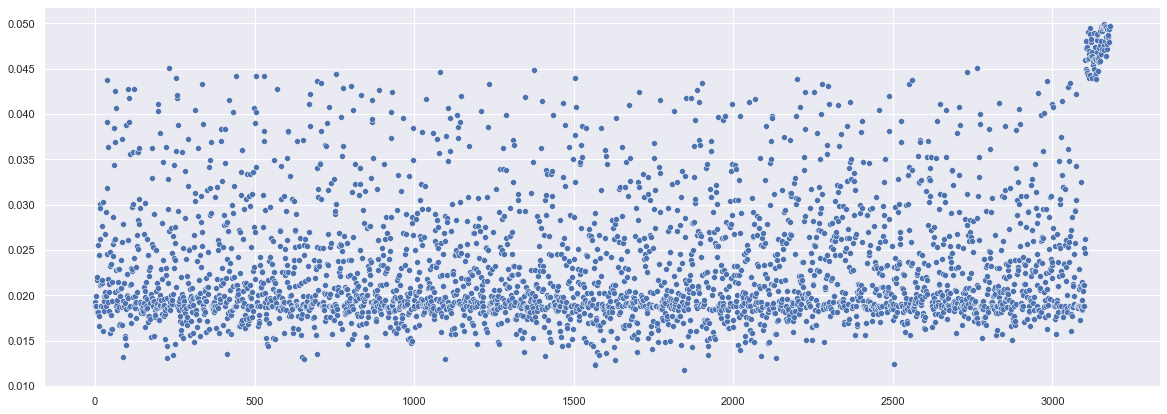

In [20]:
def new_parse(pattern, pattern_motifs):
    f = open('motifs/motifs_7_3/thamotifs%s.txt' % ''.join(map(str, pattern)), 'r')
    f.readline()
    temp_arr = []
    for line in f:
        line = list(map(float, line.split(", ")))
        temp_arr.append(line)
    
    pattern_motifs[str_subseq(pattern + (WINDOW - 1,))] = temp_arr
    f.close()
    return pattern_motifs



# loading patterns that we use
patterns_for_supercomp=[]
fi = open("patterns/patterns_supercomp_7.txt", "r")
for line in fi:
    temp = list(map(int, line.split(", ")))
    patterns_for_supercomp.append(temp)
fi.close()

new_centers = dict()
for pattern_from_file in patterns_for_supercomp:
    new_parse(tuple(pattern_from_file), new_centers)

df = pd.read_csv('data/test/part_5.csv')

distances = {}    
threshold_val = 0.05

for i in range(10):
    df_pred = df.loc[df.index == i]
    df_pred = df_pred.drop(labels=['Ticker', 'index', 'Date'], axis=1)
    df_pred = df_pred.dropna(axis=1)

    xs_temp = df_pred.values.tolist()
    xs_temp[0] = xs_temp[0][::-1]
    xs, beta, alpha = detrend(xs_temp)
    alpha = float(alpha)
    xs = list(np.array(xs).flatten())

    last_points = xs[-7:]

    
    for key, value in new_centers.items():
        for motif in value:
            temp_dist = euclidean(last_points, motif)
            if temp_dist <= threshold_val:
                print(motif, temp_dist, i)
                distances[tuple(motif)] = temp_dist 


            
            
visual_arr = list(distances.values())
print(min(visual_arr))
sns.scatterplot(y=visual_arr, x=list(range(len(visual_arr))))

0.07693960398886976


<AxesSubplot:>

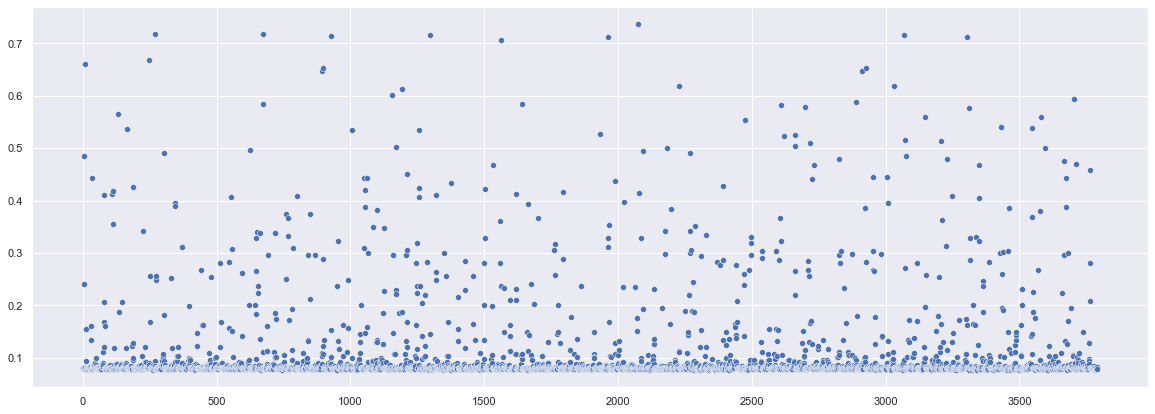

In [96]:
last_points = xs[-7:]
new_centers = dict()

for pattern_from_file in patterns_for_supercomp:
    new_parse(tuple(pattern_from_file), new_centers)

distances = {}    

for key, value in new_centers.items():
    for motif in value:
        temp_dist = euclidean(last_points, motif)
        distances[tuple(motif)] = temp_dist 

        
visual_arr = list(distances.values())
print(min(visual_arr))
sns.scatterplot(y=visual_arr, x=list(range(len(visual_arr))))

<AxesSubplot:>

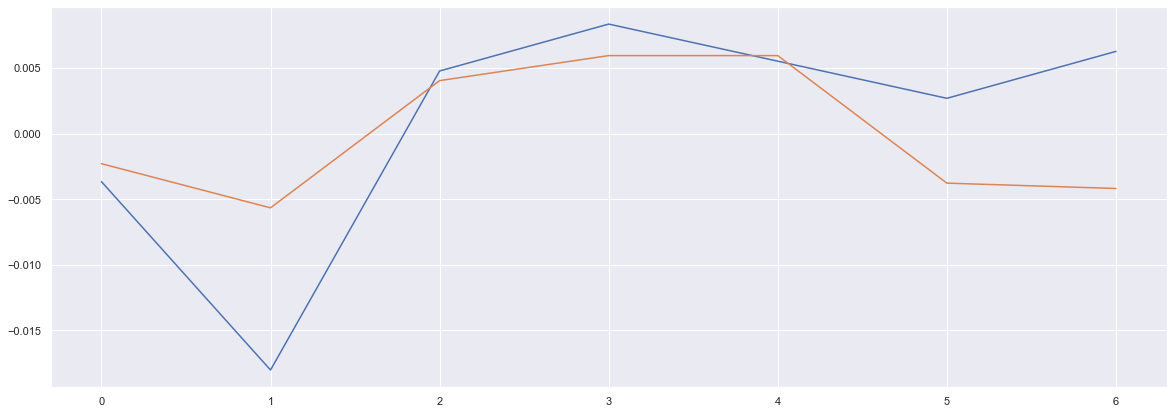

In [119]:
df = pd.read_csv('data/test/part_5.csv')

govno = [-0.0022963684960063562, -0.005663317425906242, 
         0.004038204226791868, 0.005944713902656315, 
         0.005943850611542608, -0.0037798617326519285, -0.004187221086426157]

df_pred = df.loc[df.index == 3]
df_pred = df_pred.drop(labels=['Ticker', 'index', 'Date'], axis=1)
df_pred = df_pred.dropna(axis=1)

xs_temp = df_pred.values.tolist()
xs_temp[0] = xs_temp[0][::-1]
sns.set(rc={'figure.figsize':(20,7)})
xs, beta, alpha = detrend(xs_temp)
alpha = float(alpha)
xs = list(np.array(xs).flatten())
xs = xs[-7:]
sns.lineplot(y=xs, x=list(range(len(xs))))
sns.lineplot(y=govno, x=list(range(len(govno))))
